In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
def imgshow(img):
    '''image will be displayed in gray format'''
    try:
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print(f"Exception occurred in 'imgshow' function: {e}")
    
def display_characters(characters):
    try:
        n_col = 10
        n_row = int(np.ceil(len(characters)/n_col))
        _, axs = plt.subplots(n_row, n_col, figsize=(40, 50))
        axs = axs.flatten()
        for img, ax in zip(characters, axs):
            ax.imshow(img, "gray")
        plt.show()
    except Exception as e:
        print(f"Exception occurred in 'display_characters' function: {e}")

## Image Preprocessing

In [3]:
## Adjusting brightness and contrast

def image_preprocessing(image):
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))               # Normalized image (0 to 1)
    image_mean = np.sum(image_normalized) / (image.shape[0]*image.shape[1])                    # Mean of normalized image
    #print("Image intensity mean : ", image_mean)
    if .90 > image_mean > 0.50:                    
        image = image_normalized * 255
    elif image_mean >= .90:
        clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(image.shape[0]//8, image.shape[1]//8))
        image = clahe.apply(image)
    return image
    


## Binarization
def binarization(image):  
    m = image.shape[0]
    n = image.shape[1]
    inter_class_variance = -2147483648
    threshold_by_inter_class_variance = 0
    pixel_frequency = np.zeros((256,), dtype=int)
    pixel_probability = np.zeros((256,), dtype=float)
    K = 256
    for i in range(0,m):
        for j in range(0,n):
            image[i][j] = int(round(image[i][j]))
            
    for i in range(0,m):
        for j in range(0,n):
            pixel_frequency[int(image[i][j])] += 1
    for i in range(0, m):
        for j in range(0, n):
            pixel_probability[int(image[i][j])] = pixel_frequency[int(image[i][j])] / (m*n)
    for t in range(1, K-1):
        w0 = 0                             # probability that a pixel belongs to class 0
        w1 = 0                             # probability that a pixel belongs to class 1
        for i in range(0, t+1):
            w0 += pixel_probability[i]
        w1 = 1 - w0
        m0 = 0                            # mean value of a pixel given that pixel belongs to class 0
        m1 = 0                            # mean value of a pixel given that pixel belongs to class 1
        for i in range(0, t+1):
            m0 += (i*pixel_probability[i])
        for j in range(t+1, K):
            m1 += (j*pixel_probability[j])
        m0 = m0 / w0
        m1 = m1 /w1
        mt = (w0*m0) + (w1*m1)           # Overall Image mean
        temp = (w0*pow((m0-mt), 2)) + (w1*pow((m1-mt), 2))
        if inter_class_variance <= temp:
            inter_class_variance = temp
            threshold_by_inter_class_variance = t
    binary_image = np.zeros((m,n))
    for i in range(0, m):
        for j in range(0, n):
            if image[i][j] >= threshold_by_inter_class_variance:
                binary_image[i][j] = 1
            else:
                binary_image[i][j] = 0
            
    return binary_image

## Character Segmentation

In [4]:
def line_segmentation(image):
    lines = []
    m,n = image.shape
    upperlimit = 0
    lowerlimit = 0
    i = 0
    while i<m:
        if not np.all(image[i,:]==1):
            upperlimit = i
            i1 = i+1
            while i1<m:
                if np.all(image[i1,:]==1):
                    lowerlimit = i1-1
                    if abs(upperlimit-lowerlimit) > 5:
                        lines.append(image[upperlimit:lowerlimit+1,:])
                        break
                    else:
                        break
                i1 += 1
            i = i1
        i += 1
    print("\n\nTotal Lines : ", len(lines))
    for line in lines:
        imgshow(line)
    return lines

In [5]:
def touching_character_segmentation(characters): 
    num = -1
    chars = []
    index = 0
    for character in characters:
        num += 1
        m,n = character.shape
        
        if n >= m*0.80:
            imgshow(character)
            vpp = []
            tdp = []
            for j in range(0,n):
                vpp.append(len(np.where(character[:,j]==0)[0]))
                tdp.append(m - np.where(character[:,j]==0)[0][0])
            #print(vpp)
            #print(tdp)
            #imgshow(vpp)
            #imgshow(tdp)      
            
            score = np.array(vpp) + np.array(tdp)*1.2
            #imgshow(score)
            leftlimit = int(n*.1)
            rightlimit = int(m*.6)
            count = 0
            char_num=0   
            
            while (rightlimit < n):
                score_sorted = np.sort(score[leftlimit:rightlimit])
                first_boundary_point_value = score_sorted[0]
                boundary_point = -np.sort(-np.where(score[leftlimit:rightlimit]==first_boundary_point_value)[0])[0]
                char = character[:,leftlimit*count:boundary_point]
                #imgshow(char)
                chars.append(char)
                leftlimit = boundary_point+1
                rightlimit = int(m*(.8 + (boundary_point*100)/n))
                count = 1
                
            if abs(leftlimit-rightlimit) > m*.2:   
                char = character[:,leftlimit:n]
                #imgshow(char)
                chars.append(char)
            index += 1
            
        if index < len(characters):
            chars.append(characters[index])
        index += 1
    
    return chars
      
            
#touching_character_segmentation(characters)

In [6]:
def character_segmentation(line, characters):
    m,n = line.shape
    leftlimit= 0
    rightlimit = 0
    j=0
    while j < n:
        if not np.all(line[:,j]==1):
            leftlimit = j
            j1 = j+1
            while j1 < n:
                if np.all(line[:,j1]==1):
                    rightlimit = j1-1
                    if abs(leftlimit - rightlimit) > 5:
                        characters.append(line[:,leftlimit:rightlimit+1])
                        break
                    else:
                        break
                j1 += 1
            j = j1
        j += 1
    return characters

In [7]:
def segmentation(image):
    m,n = image.shape
    characters = []
    lines = line_segmentation(image)
    for line in lines:
        character_segmentation(line, characters)
    #characters = touching_character_segmentation(characters)
    return characters

## Image Loading

Image Size :  (278, 1512, 3)

Original Image : 


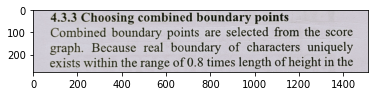

Gray image with adjusting brightness and contrast : 


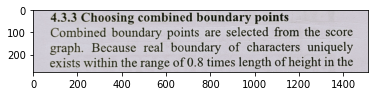

Binary image : 


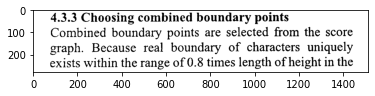



Total Lines :  4


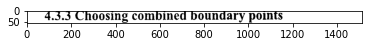

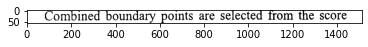

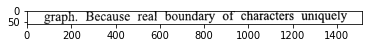

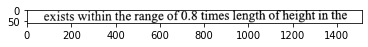

In [8]:
img = "img1.jpg"
path = os.path.join("images", img)
image = cv2.imread(path)
print("Image Size : ", image.shape)
print("\nOriginal Image : ")
imgshow(image)
if len(image.shape) == 3:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)              # convert rgb image to grayscale
    
    
gray_image = image_preprocessing(gray_image)
print("Gray image with adjusting brightness and contrast : ")
imgshow(image)

image = binarization(gray_image)
#ret, image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

print("Binary image : ")
imgshow(image)

characters = segmentation(image)

## Display Characters

Total characters :  168


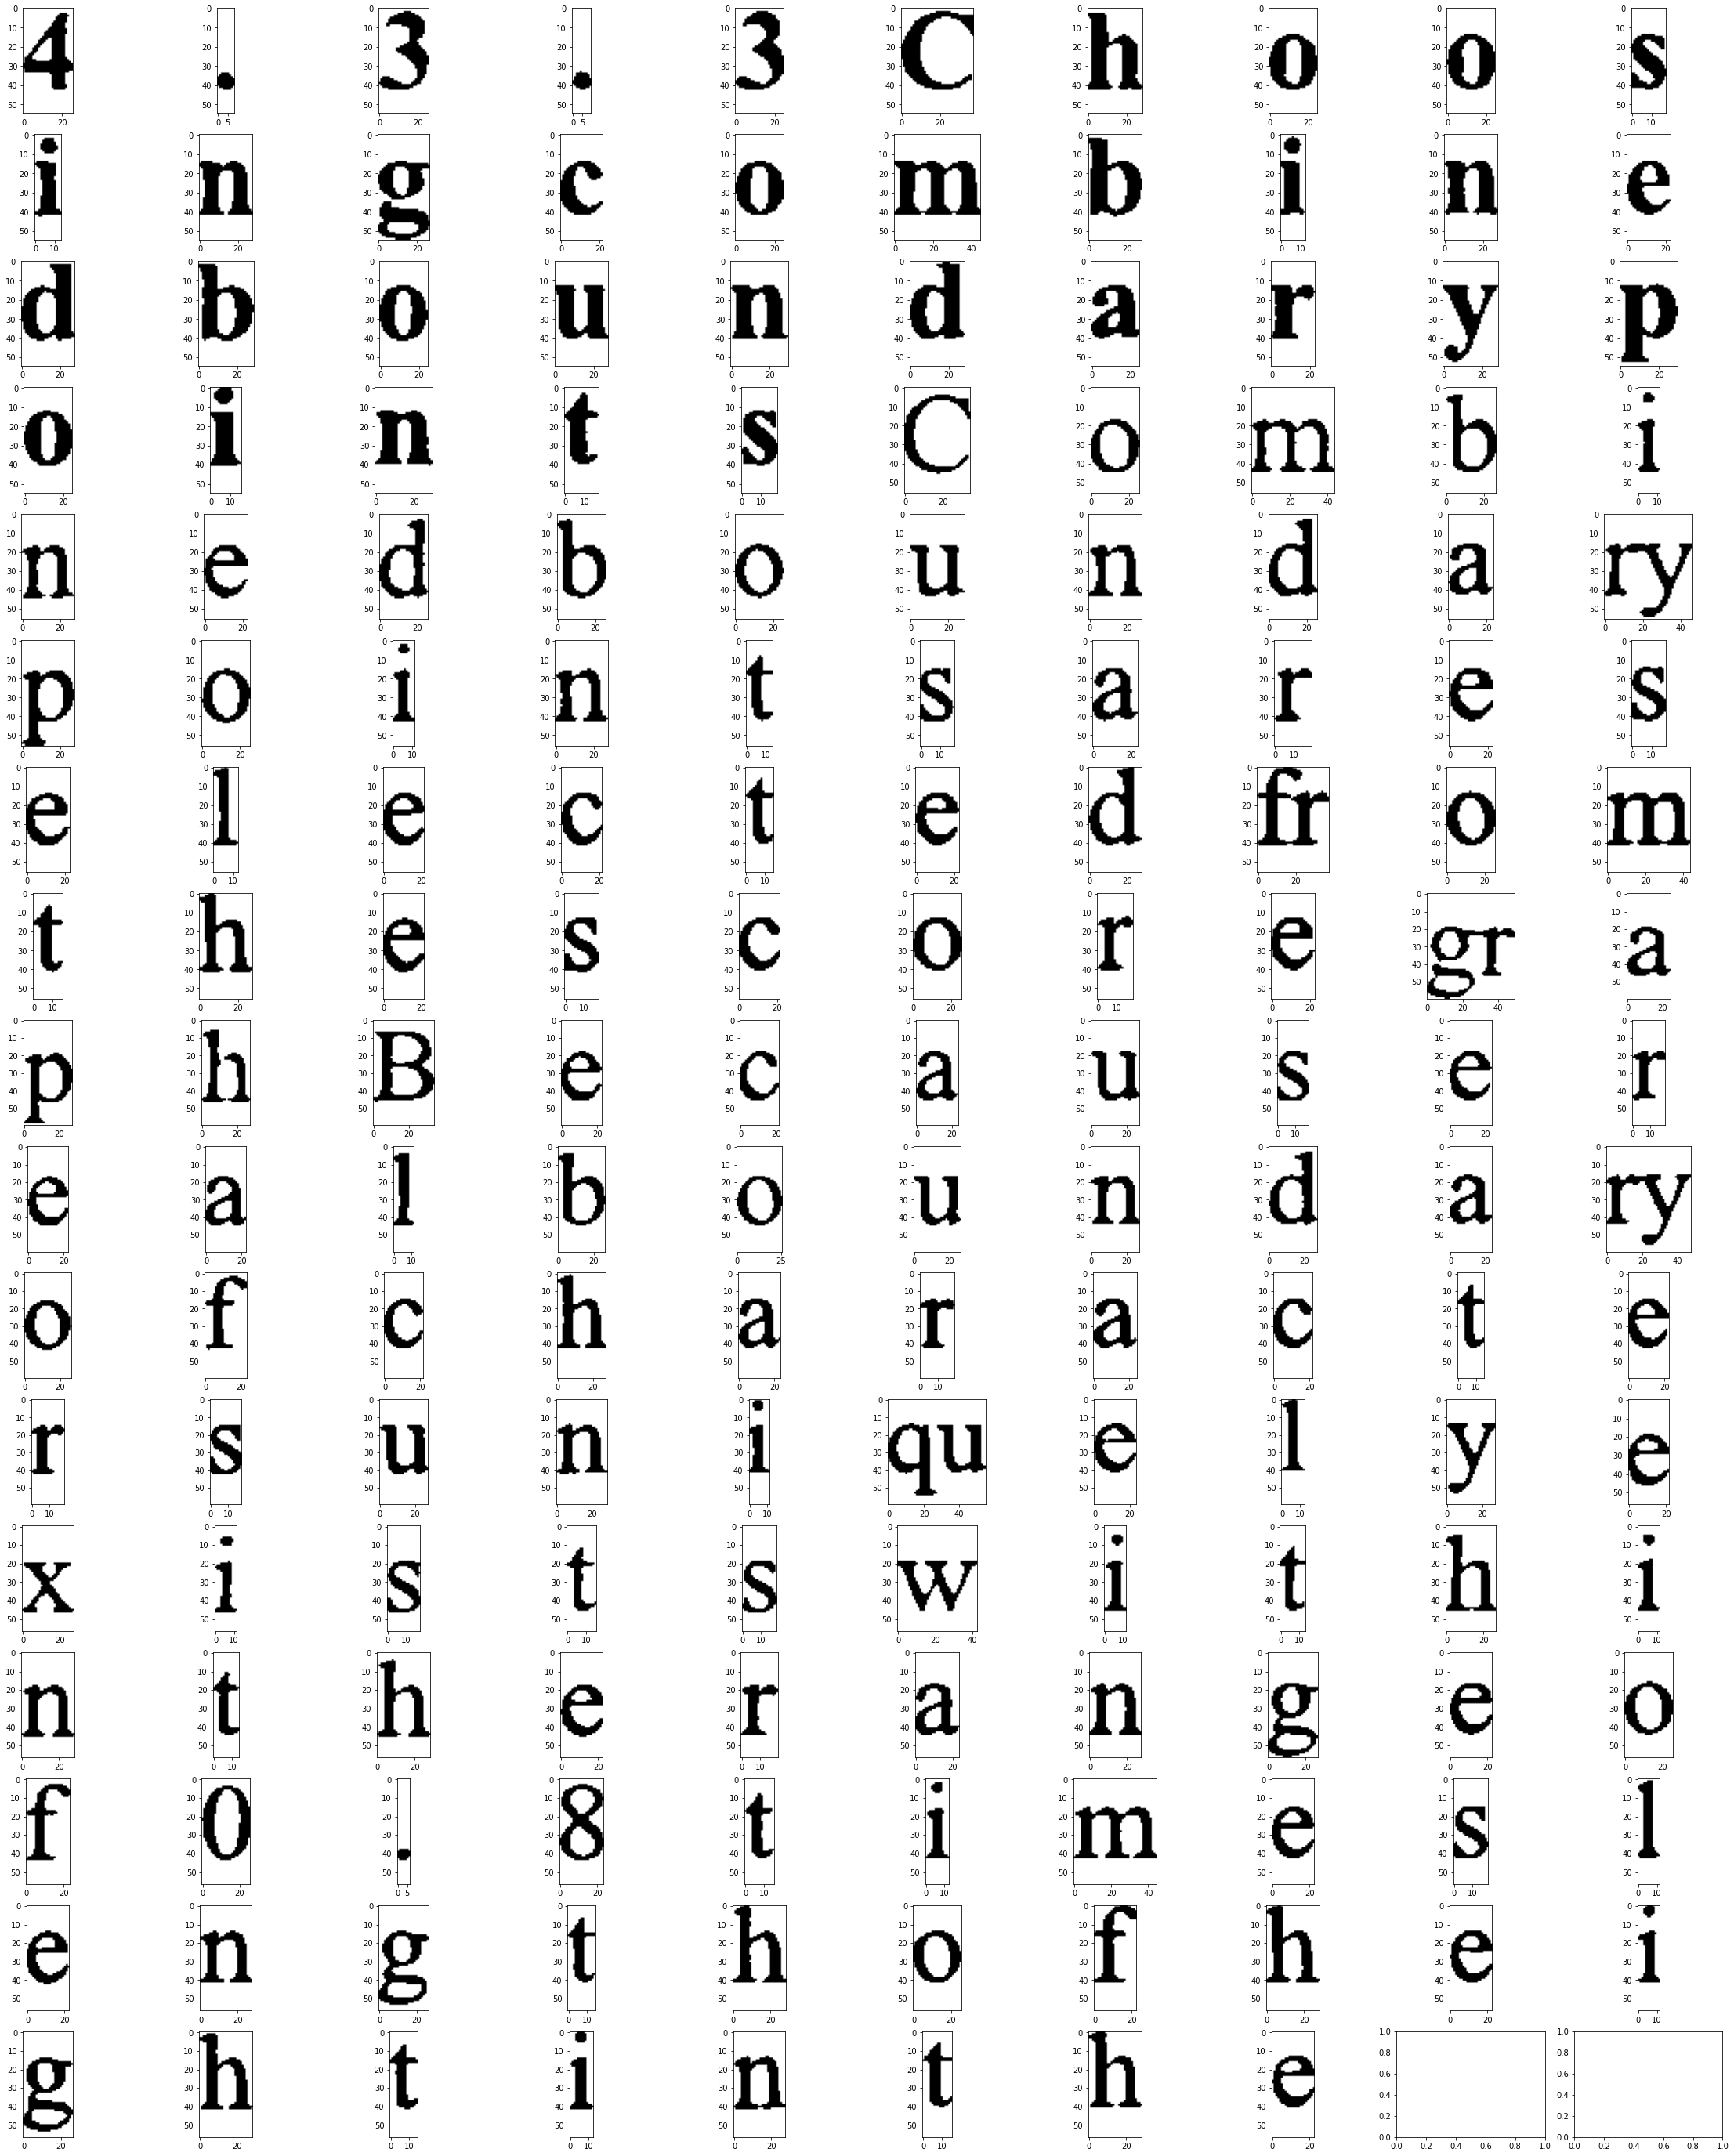

In [9]:
print("Total characters : ", len(characters))
display_characters(characters)